In [1]:
import tensorflow as tf, numpy as np, time, random, os, math, pandas as pd, matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, mixed_precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import gc, json, pathlib, math, time
from copy import deepcopy
import json, pathlib, pickle
tf.config.optimizer.set_jit(True)
mixed_precision.set_global_policy("mixed_float16")

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
# нормалізація до [0,1]
x_train = x_train.astype("float16") / 255.0
x_test  = x_test .astype("float16") / 255.0

# one-hot мітки (10 класів)
y_train = tf.keras.utils.to_categorical(y_train, 10).astype("float16")
y_test  = tf.keras.utils.to_categorical(y_test , 10).astype("float16")

# розбиття train/val (90 / 10 %)
VAL_SPLIT = 0.1
val_size  = int(len(x_train) * VAL_SPLIT)

x_val, y_val = x_train[-val_size:], y_train[-val_size:]
x_train, y_train = x_train[:-val_size], y_train[:-val_size]

AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(images, labels, batch_size=128, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(images), seed=SEED)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(x_train, y_train, shuffle=True)
val_ds   = make_dataset(x_val,   y_val)
test_ds  = make_dataset(x_test,  y_test)

print(f"Train: {len(x_train)} | Val: {len(x_val)} | Test: {len(x_test)}")

Train: 45000 | Val: 5000 | Test: 10000


In [4]:
def build_model(learning_rate=1e-3,
                dropout_rate=0.3,
                n_filters_conv1=32,
                n_dense_units=256):

    inputs = layers.Input(shape=(32, 32, 3))

    x = layers.Conv2D(n_filters_conv1, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(n_filters_conv1*2, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(n_filters_conv1*4, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(n_dense_units, activation="relu")(x)
    outputs = layers.Dense(10, activation="softmax", dtype="float32")(x)

    model = models.Model(inputs, outputs, name="baseline_cnn")
    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model


model_tmp = build_model()
model_tmp.summary()
tf.keras.backend.clear_session()

Model: "baseline_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,193,898 (8.37 MB)

 Trainable params: 2,193,450 (8.37 MB)

 Non-trainable params: 448 (1.75 KB)

In [5]:
BATCH_SIZE = 128
EPOCHS_FAST = 20

baseline_model = build_model()
t0 = time.perf_counter()
history = baseline_model.fit(
    train_ds,
    epochs=EPOCHS_FAST,
    validation_data=val_ds,
    verbose=2
)
time_baseline = time.perf_counter() - t0

val_acc_baseline = history.history["val_accuracy"][-1]

test_loss, test_acc_baseline = baseline_model.evaluate(test_ds, verbose=0)

print(f"\nTrain time: {time_baseline:.1f} с")
print(f"Val acc: {val_acc_baseline:.4f} | Test acc: {test_acc_baseline:.4f}")

Epoch 1/20
352/352 - 17s - 47ms/step - accuracy: 0.4205 - loss: 1.7210 - val_accuracy: 0.2752 - val_loss: 2.1340
Epoch 2/20
352/352 - 1s - 4ms/step - accuracy: 0.6233 - loss: 1.0595 - val_accuracy: 0.6380 - val_loss: 1.0482
Epoch 3/20
352/352 - 1s - 4ms/step - accuracy: 0.6832 - loss: 0.8951 - val_accuracy: 0.6512 - val_loss: 1.0292
Epoch 4/20
352/352 - 1s - 4ms/step - accuracy: 0.7184 - loss: 0.7963 - val_accuracy: 0.6872 - val_loss: 0.9149
Epoch 5/20
352/352 - 1s - 4ms/step - accuracy: 0.7428 - loss: 0.7331 - val_accuracy: 0.6430 - val_loss: 1.0946
Epoch 6/20
352/352 - 1s - 4ms/step - accuracy: 0.7635 - loss: 0.6746 - val_accuracy: 0.6778 - val_loss: 0.9134
Epoch 7/20
352/352 - 1s - 4ms/step - accuracy: 0.7779 - loss: 0.6289 - val_accuracy: 0.7560 - val_loss: 0.7302
Epoch 8/20
352/352 - 1s - 4ms/step - accuracy: 0.7897 - loss: 0.6011 - val_accuracy: 0.7454 - val_loss: 0.7713
Epoch 9/20
352/352 - 1s - 4ms/step - accuracy: 0.8035 - loss: 0.5587 - val_accuracy: 0.7626 - val_loss: 0.7010

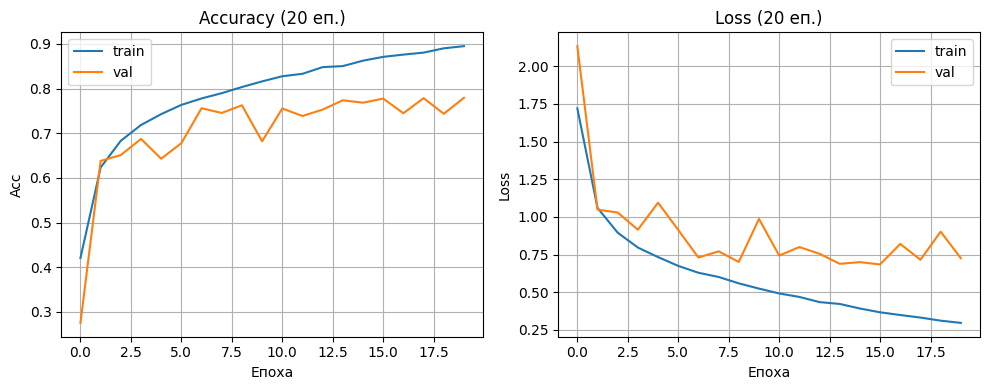

In [6]:
plt.figure(figsize=(10,4))

# accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy (20 еп.)")
plt.xlabel("Епоха"); plt.ylabel("Acc"); plt.grid(True); plt.legend()

# loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss (20 еп.)")
plt.xlabel("Епоха"); plt.ylabel("Loss"); plt.grid(True); plt.legend()

plt.tight_layout(); plt.show()

In [7]:
baseline_stats = {
    "val_acc_baseline": float(val_acc_baseline),
    "test_acc_baseline": float(test_acc_baseline),
    "time_baseline_s":  float(time_baseline)
}

path = pathlib.Path("baseline_stats.json")
with path.open("w") as f:
    json.dump(baseline_stats, f, indent=2)
print("baseline_stats.json збережено.")

baseline_stats.json збережено.


In [8]:
PARAM_SPACE = {
    "learning_rate":   (1e-5, 5e-3, "log"),
    "dropout_rate":    (0.10, 0.45, "lin"),
    "n_filters_conv1": (16,   64,   "int"),
    "n_dense_units":   (128,  512,  "int"),
}

PARAM_NAMES = list(PARAM_SPACE.keys())
LO = np.array([PARAM_SPACE[p][0] for p in PARAM_NAMES], dtype=np.float32)
HI = np.array([PARAM_SPACE[p][1] for p in PARAM_NAMES], dtype=np.float32)
SCALES = [PARAM_SPACE[p][2] for p in PARAM_NAMES]

def vec_to_params(vec):
    d = {}
    for i, name in enumerate(PARAM_NAMES):
        lo, hi, scale = PARAM_SPACE[name]
        if scale == "log":
            val = 10 ** ( math.log10(lo) + vec[i] * (math.log10(hi) - math.log10(lo)) )
        else:
            val = lo + vec[i] * (hi - lo)
        if scale == "int":
            val = int(round(val))
        else:
            val = float(val)
        d[name] = val
    return d

def params_to_vec(hp: dict) -> np.ndarray:
    vec = []
    for i, name in enumerate(PARAM_NAMES):
        lo, hi, scale = PARAM_SPACE[name]
        v = hp[name]
        if scale == "log":
            v = (math.log10(v) - math.log10(lo)) / (math.log10(hi) - math.log10(lo))
        else:
            v = (v - lo) / (hi - lo)
        vec.append(v)
    return np.array(vec, dtype=np.float32)

def clamp01(v):                               # гарантія меж [0,1]
    return np.clip(v, 0.0, 1.0, dtype=np.float32)

In [9]:
EPOCHS_FIT   = 3
BATCH_FIT    = 128
STEPS_LIMIT  = 64

def fitness(u):
    hp = vec_to_params(u)
    model = build_model(**hp)

    hist = model.fit(
        train_ds,
        epochs=EPOCHS_FIT,
        validation_data=val_ds,
        batch_size=BATCH_FIT,
        steps_per_epoch=STEPS_LIMIT,
        verbose=0,
    )
    val_acc = float(hist.history["val_accuracy"][-1])

    # чистимо GPU-пам'ять
    tf.keras.backend.clear_session()
    gc.collect()
    return 1.0 - val_acc

In [10]:
POP_SIZE = 40
F, CR    = 0.9, 1.0
MAX_GEN  = 15

# ініціалізація популяції
pop  = np.random.rand(POP_SIZE, len(PARAM_SPACE)).astype(np.float32)

# додаємо baseline-hp (lr=1e-3, dr=0.3, 32, 256)
baseline_hp = dict(learning_rate=1e-3,
                   dropout_rate=0.30,
                   n_filters_conv1=32,
                   n_dense_units=256)
pop[0] = params_to_vec(baseline_hp)

# оцінюємо популяцію
fits = np.zeros(POP_SIZE, dtype=np.float32)
print("Initial evaluation …")
for i in range(POP_SIZE):
    fits[i] = fitness(pop[i])

best_idx  = int(np.argmin(fits))
best_u    = pop[best_idx].copy()
best_fit  = fits[best_idx]
history_best = [best_fit]
print(f"Gen 0 | best val_acc = {1-best_fit:.4f}")

t0_de = time.perf_counter()

# цикл DE
for gen in range(1, MAX_GEN + 1):
    for i in range(POP_SIZE):
        # добираємо a, b, c ≠ i
        idxs = np.array([j for j in range(POP_SIZE) if j != i])
        a, b, c = pop[np.random.choice(idxs, 3, replace=False)]

        # мутант
        mutant = clamp01(a + F * (b - c))

        # binomial crossover
        cross_mask = np.random.rand(len(PARAM_SPACE)) < CR
        if not cross_mask.any():
            cross_mask[np.random.randint(0, len(PARAM_SPACE))] = True
        trial = np.where(cross_mask, mutant, pop[i])

        # оцінка
        trial_fit = fitness(trial)

        # відбір
        if trial_fit < fits[i]:
            pop[i]  = trial
            fits[i] = trial_fit
            if trial_fit < best_fit:
                best_fit = trial_fit
                best_u   = trial.copy()

    history_best.append(best_fit)
    print(f"Gen {gen:02}/{MAX_GEN} | best val_acc = {1-best_fit:.4f}")

t_de = time.perf_counter() - t0_de
best_params = vec_to_params(best_u)

print(f"\n DE completed in {t_de/60:.1f} min.")
print("Best hyper-parameters:", best_params)

Initial evaluation …
Gen 0 | best val_acc = 0.1986
Gen 01/15 | best val_acc = 0.3074
Gen 02/15 | best val_acc = 0.3074
Gen 03/15 | best val_acc = 0.3074
Gen 04/15 | best val_acc = 0.3074
Gen 05/15 | best val_acc = 0.3074
Gen 06/15 | best val_acc = 0.3472
Gen 07/15 | best val_acc = 0.3472
Gen 08/15 | best val_acc = 0.3472
Gen 09/15 | best val_acc = 0.3472
Gen 10/15 | best val_acc = 0.3472
Gen 11/15 | best val_acc = 0.3472
Gen 12/15 | best val_acc = 0.3610
Gen 13/15 | best val_acc = 0.3610
Gen 14/15 | best val_acc = 0.3610
Gen 15/15 | best val_acc = 0.3610

 DE completed in 158.7 min.
Best hyper-parameters: {'learning_rate': 0.005000000819563866, 'dropout_rate': 0.1687418520450592, 'n_filters_conv1': 17, 'n_dense_units': 435}


In [11]:
with pathlib.Path("best_params.json").open("w") as f:
    json.dump(best_params, f, indent=2)

np.save("de_history.npy", np.array(history_best, dtype=np.float32))
print("best_params.json та de_history.npy збережено.")

best_params.json та de_history.npy збережено.


In [12]:
# baseline
with pathlib.Path("baseline_stats.json").open() as f:
    base = json.load(f)
val_acc_baseline  = base["val_acc_baseline"]
test_acc_baseline = base["test_acc_baseline"]
time_baseline     = base["time_baseline_s"]

# best params
with pathlib.Path("best_params.json").open() as f:
    best_params = json.load(f)

print("Best hyper-parameters:", best_params)

Best hyper-parameters: {'learning_rate': 0.005000000819563866, 'dropout_rate': 0.1687418520450592, 'n_filters_conv1': 17, 'n_dense_units': 435}


In [13]:
EPOCHS_FULL = 50
BATCH_FULL  = 128

model_opt = build_model(**best_params)

ckpt_path = "final_best.weights.h5"

callbacks = [
    EarlyStopping(patience=7, restore_best_weights=True, monitor="val_accuracy"),
    ModelCheckpoint(ckpt_path, save_best_only=True, save_weights_only=True,
                    monitor="val_accuracy", verbose=0),
]

t0_opt = time.perf_counter()
hist_opt = model_opt.fit(
    train_ds,
    epochs=EPOCHS_FULL,
    validation_data=val_ds,
    batch_size=BATCH_FULL,
    verbose=2,
    callbacks=callbacks,
)
time_opt = time.perf_counter() - t0_opt

val_acc_opt  = hist_opt.history["val_accuracy"][-1]
test_loss, test_acc_opt = model_opt.evaluate(test_ds, verbose=0)

print(f"\n Train time (opt): {time_opt/60:.1f} хв")
print(f"Val acc: {val_acc_opt:.4f} | Test acc: {test_acc_opt:.4f}")

tf.keras.backend.clear_session(); gc.collect();

Epoch 1/50
352/352 - 13s - 38ms/step - accuracy: 0.3260 - loss: 2.6629 - val_accuracy: 0.4098 - val_loss: 1.6018
Epoch 2/50
352/352 - 1s - 4ms/step - accuracy: 0.5098 - loss: 1.3603 - val_accuracy: 0.4062 - val_loss: 1.8605
Epoch 3/50
352/352 - 1s - 4ms/step - accuracy: 0.6086 - loss: 1.0974 - val_accuracy: 0.6484 - val_loss: 1.0025
Epoch 4/50
352/352 - 1s - 4ms/step - accuracy: 0.6686 - loss: 0.9402 - val_accuracy: 0.6756 - val_loss: 0.9245
Epoch 5/50
352/352 - 1s - 4ms/step - accuracy: 0.7060 - loss: 0.8440 - val_accuracy: 0.6892 - val_loss: 0.8913
Epoch 6/50
352/352 - 1s - 4ms/step - accuracy: 0.7334 - loss: 0.7617 - val_accuracy: 0.7226 - val_loss: 0.8173
Epoch 7/50
352/352 - 1s - 4ms/step - accuracy: 0.7533 - loss: 0.7023 - val_accuracy: 0.6638 - val_loss: 0.9836
Epoch 8/50
352/352 - 1s - 4ms/step - accuracy: 0.7730 - loss: 0.6528 - val_accuracy: 0.6776 - val_loss: 0.9914
Epoch 9/50
352/352 - 1s - 4ms/step - accuracy: 0.7866 - loss: 0.6091 - val_accuracy: 0.6376 - val_loss: 1.0985

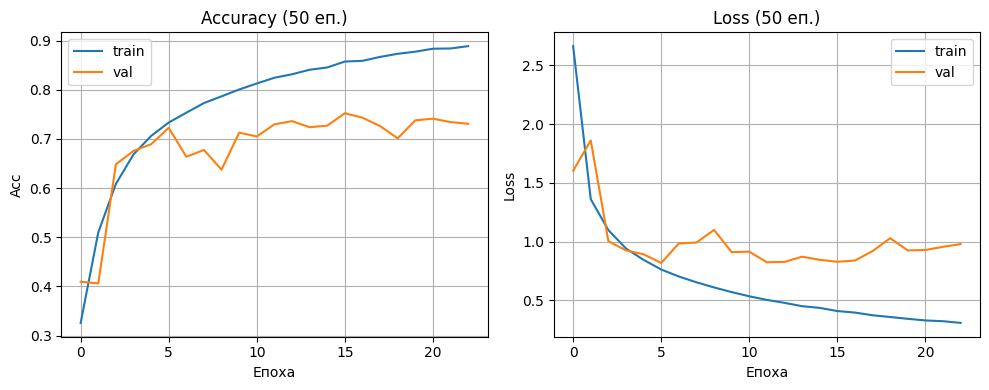

In [14]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(hist_opt.history["accuracy"], label="train")
plt.plot(hist_opt.history["val_accuracy"], label="val")
plt.title(f"Accuracy ({EPOCHS_FULL} еп.)")
plt.xlabel("Епоха")
plt.ylabel("Acc")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_opt.history["loss"], label="train")
plt.plot(hist_opt.history["val_loss"], label="val")
plt.title(f"Loss ({EPOCHS_FULL} еп.)")
plt.xlabel("Епоха")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

,model,val_acc,test_acc,train_time_s
0,baseline,0.7794,0.7681,43.972466
1,DE-optimized,0.7308,0.7399,44.023629


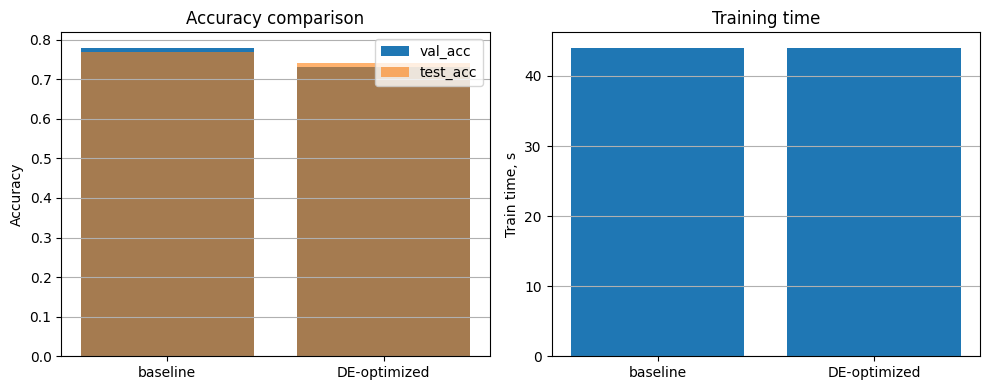

In [15]:
df_cmp = pd.DataFrame({
    "model":         ["baseline", "DE-optimized"],
    "val_acc":       [val_acc_baseline, val_acc_opt],
    "test_acc":      [test_acc_baseline, test_acc_opt],
    "train_time_s":  [time_baseline,     time_opt]
})
display(df_cmp)

# bar-charts
fig, ax = plt.subplots(1, 2, figsize=(10,4))

# accuracy
ax[0].bar(df_cmp["model"], df_cmp["val_acc"], label="val_acc")
ax[0].bar(df_cmp["model"], df_cmp["test_acc"], alpha=0.6, label="test_acc")
ax[0].set_ylabel("Accuracy"); ax[0].set_title("Accuracy comparison"); ax[0].legend(); ax[0].grid(True, axis="y")

# time
ax[1].bar(df_cmp["model"], df_cmp["train_time_s"])
ax[1].set_ylabel("Train time, s"); ax[1].set_title("Training time"); ax[1].grid(True, axis="y")

plt.tight_layout(); plt.show()

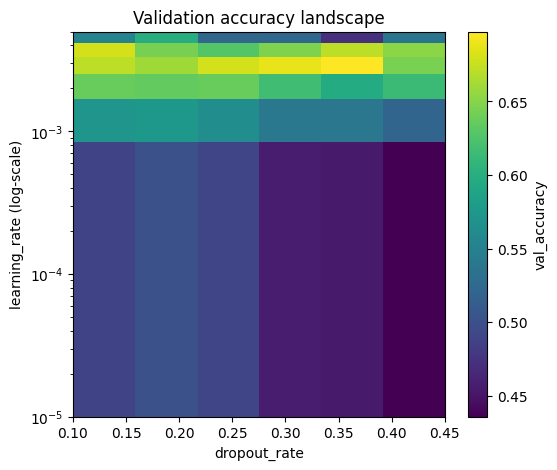

In [16]:
# ландшафт val_acc: learning_rate × dropout_rate
GRID = 6                           # було 10
EPOCHS_FIT = 3                     # лише 1 епоха для візуалізації

lr_vals = np.logspace(math.log10(1e-5), math.log10(5e-3), GRID)
dr_vals = np.linspace(0.10, 0.45, GRID)

heat = np.zeros((GRID, GRID), dtype=np.float32)

for i, lr in enumerate(lr_vals):
    for j, dr in enumerate(dr_vals):
        hp = dict(best_params)
        hp["learning_rate"]  = float(lr)
        hp["dropout_rate"]   = float(dr)

        model_tmp = build_model(**hp)
        h = model_tmp.fit(
            train_ds,
            epochs=EPOCHS_FIT,
            validation_data=val_ds,
            batch_size=BATCH_FIT,
            verbose=0,
        )
        heat[i, j] = h.history["val_accuracy"][-1]
        tf.keras.backend.clear_session(); gc.collect()

plt.figure(figsize=(6,5))
plt.imshow(heat, origin="lower",
           extent=[dr_vals.min(), dr_vals.max(), lr_vals.min(), lr_vals.max()],
           aspect="auto", cmap="viridis")
plt.colorbar(label="val_accuracy")
plt.xlabel("dropout_rate"); plt.ylabel("learning_rate (log-scale)")
plt.yscale("log")
plt.title("Validation accuracy landscape")
plt.show()

In [17]:
final_stats = {
    "val_acc_opt":   float(val_acc_opt),
    "test_acc_opt":  float(test_acc_opt),
    "time_opt_s":    float(time_opt),
    "best_params":   best_params,
}
with pathlib.Path("final_stats.json").open("w") as f:
    json.dump(final_stats, f, indent=2)

print("final_stats.json збережено")

final_stats.json збережено
